In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
# from tensorflow.keras.backend.tensorflow_backend import set_session
import keras, sys, time, os, warnings, cv2

from keras.models import *
from keras.layers import *

import numpy as np
import pandas as pd 
# warnings.filterwarnings("ignore")


# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.95
# config.gpu_options.visible_device_list = "1" 
# set_session(tf.Session(config=config))   


# print("python {}".format(sys.version))
# print("keras version {}".format(keras.__version__)); del keras
# print("tensorflow version {}".format(tf.__version__))

In [2]:
FTRAIN = "data/training.csv"
FTEST  = "data/test.csv"
FIdLookup = 'data/IdLookupTable.csv'

In [3]:
def gaussian_k(x0,y0,sigma, width, height):
        """ Make a square gaussian kernel centered at (x0, y0) with sigma as SD.
        """
        x = np.arange(0, width, 1, float) ## (width,)
        y = np.arange(0, height, 1, float)[:, np.newaxis] ## (height,1)
        return np.exp(-((x-x0)**2 + (y-y0)**2) / (2*sigma**2))

def generate_hm(height, width ,landmarks,s=3):
        """ Generate a full Heap Map for every landmarks in an array
        Args:
            height    : The height of Heat Map (the height of target output)
            width     : The width  of Heat Map (the width of target output)
            joints    : [(x1,y1),(x2,y2)...] containing landmarks
            maxlenght : Lenght of the Bounding Box
        """
        Nlandmarks = len(landmarks)
        hm = np.zeros((height, width, Nlandmarks), dtype = np.float32)
        for i in range(Nlandmarks):
            if not np.array_equal(landmarks[i], [-1,-1]):
             
                hm[:,:,i] = gaussian_k(landmarks[i][0],
                                        landmarks[i][1],
                                        s,height, width)
            else:
                hm[:,:,i] = np.zeros((height,width))
        return hm
    
def get_y_as_heatmap(df,height,width, sigma):
    
    columns_lmxy = df.columns[:-1] ## the last column contains Image
    columns_lm = [] 
    for c in columns_lmxy:
        c = c[:-2]
        if c not in columns_lm:
            columns_lm.extend([c])
    
    y_train = []
    for i in range(df.shape[0]):
        landmarks = []
        for colnm in columns_lm:
            x = df[colnm + "_x"].iloc[i]
            y = df[colnm + "_y"].iloc[i]
            if np.isnan(x) or np.isnan(y):
                x, y = -1, -1
            landmarks.append([x,y])
            
        y_train.append(generate_hm(height, width, landmarks, sigma))
    y_train = np.array(y_train)
    
    
    return(y_train,df[columns_lmxy],columns_lmxy)

In [4]:
def load(test=False, width=96,height=96,sigma=5):
    """
    load test/train data
    cols : a list containing landmark label names.
           If this is specified, only the subset of the landmark labels are 
           extracted. for example, cols could be:
           
          [left_eye_center_x, left_eye_center_y]
            
    return: 
    X:  2-d numpy array (Nsample, Ncol*Nrow)
    y:  2-d numpy array (Nsample, Nlandmarks*2) 
        In total there are 15 landmarks. 
        As x and y coordinates are recorded, u.shape = (Nsample,30)
    y0: panda dataframe containins the landmarks
       
    """
    from sklearn.utils import shuffle
    
    fname = FTEST if test else FTRAIN
    df = pd.read_csv(os.path.expanduser(fname)) 

    
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))


    myprint = df.count()
    myprint = myprint.reset_index()
    print(myprint)  
    ## row with at least one NA columns are removed!
    ## df = df.dropna()  
    df = df.fillna(-1)

    X = np.vstack(df['Image'].values) / 255.  # changes valeus between 0 and 1
    X = X.astype(np.float32)

    if not test:  # labels only exists for the training data
        y, y0, nm_landmark = get_y_as_heatmap(df,height,width, sigma)
        X, y, y0 = shuffle(X, y, y0, random_state=42)  # shuffle data   
        y = y.astype(np.float32)
    else:
        y, y0, nm_landmark = None, None, None
    
    return X, y, y0, nm_landmark

def load2d(test=False,width=96,height=96,sigma=5):

    re   = load(test,width,height,sigma)
    X    = re[0].reshape(-1,width,height,1)
    y, y0, nm_landmarks = re[1:]
    
    return X, y, y0, nm_landmarks

In [5]:
sigma = 5

X_train, y_train, y_train0, nm_landmarks = load2d(test=False,sigma=sigma)
X_test,  y_test, _, _ = load2d(test=True,sigma=sigma)
print(X_train.shape,y_train.shape, y_train0.shape)
print(X_test.shape,y_test)

                        index     0
0           left_eye_center_x  7039
1           left_eye_center_y  7039
2          right_eye_center_x  7036
3          right_eye_center_y  7036
4     left_eye_inner_corner_x  2271
5     left_eye_inner_corner_y  2271
6     left_eye_outer_corner_x  2267
7     left_eye_outer_corner_y  2267
8    right_eye_inner_corner_x  2268
9    right_eye_inner_corner_y  2268
10   right_eye_outer_corner_x  2268
11   right_eye_outer_corner_y  2268
12   left_eyebrow_inner_end_x  2270
13   left_eyebrow_inner_end_y  2270
14   left_eyebrow_outer_end_x  2225
15   left_eyebrow_outer_end_y  2225
16  right_eyebrow_inner_end_x  2270
17  right_eyebrow_inner_end_y  2270
18  right_eyebrow_outer_end_x  2236
19  right_eyebrow_outer_end_y  2236
20                 nose_tip_x  7049
21                 nose_tip_y  7049
22        mouth_left_corner_x  2269
23        mouth_left_corner_y  2269
24       mouth_right_corner_x  2270
25       mouth_right_corner_y  2270
26     mouth_center_top_lip_

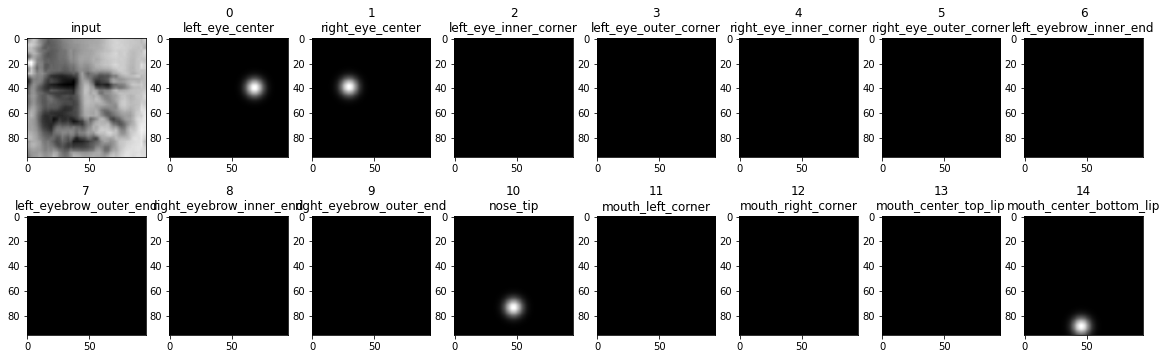

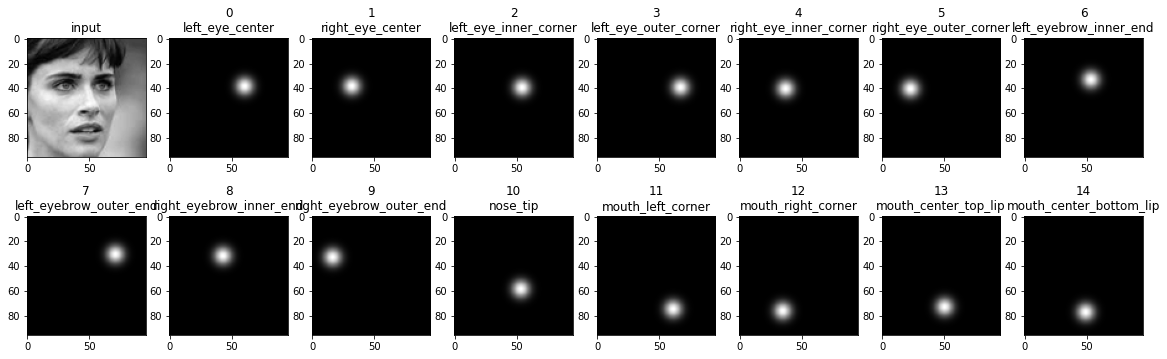

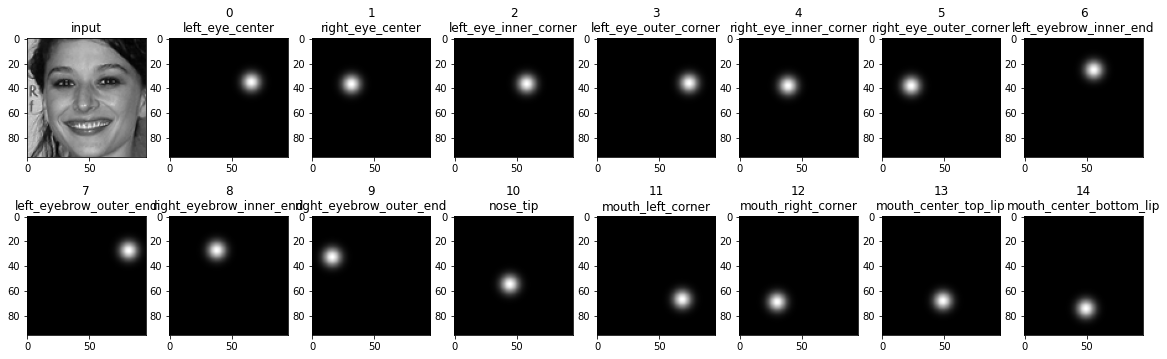

In [6]:
Nplot = y_train.shape[3]+1

for i in range(3):
    fig = plt.figure(figsize=(20,6))
    ax = fig.add_subplot(2,Nplot//2,1)
    ax.imshow(X_train[i,:,:,0],cmap="gray")
    ax.set_title("input")
    for j, lab in enumerate(nm_landmarks[::2]):
        ax = fig.add_subplot(2,Nplot//2,j+2)
        ax.imshow(y_train[i,:,:,j],cmap="gray")
        ax.set_title(str(j) +"\n" + lab[:-2] )
    plt.show()

In [7]:
landmark_order = {"orig" : [0,1,2,3,4,5,6,7,8,9,11,12],
                  "new"  : [1,0,4,5,2,3,8,9,6,7,12,11]}

In [8]:
from skimage import transform
from skimage.transform import SimilarityTransform, AffineTransform
import random 


def transform_img(data,
                  loc_w_batch=2,
                  max_rotation=0.01,
                  max_shift=2,
                  max_shear=0,
                  max_scale=0.01,mode="edge"):
    '''
    data : list of numpy arrays containing a single image
    e.g., data = [X, y, w] or data = [X, y]
    X.shape = (height, width, NfeatX)
    y.shape = (height, width, Nfeaty)
    w.shape = (height, width, Nfeatw)
    NfeatX, Nfeaty and Nfeatw can be different
    
    affine transformation for a single image
    
    loc_w_batch : the location of the weights in the fourth dimention
    [,,,loc_w_batch]
    '''
    scale = (np.random.uniform(1-max_scale, 1 + max_scale),
             np.random.uniform(1-max_scale, 1 + max_scale))
    rotation_tmp = np.random.uniform(-1*max_rotation, max_rotation)
    translation = (np.random.uniform(-1*max_shift, max_shift),
                   np.random.uniform(-1*max_shift, max_shift))
    shear = np.random.uniform(-1*max_shear, max_shear)
    tform = AffineTransform(
            scale=scale,#,
            ## Convert angles from degrees to radians.
            rotation=np.deg2rad(rotation_tmp),
            translation=translation,
            shear=np.deg2rad(shear)
        )
    
    for idata, d in enumerate(data):
        if idata != loc_w_batch:
            ## We do NOT need to do affine transformation for weights
            ## as weights are fixed for each (image,landmark) combination
            data[idata] = transform.warp(d, tform,mode=mode)
    return data
def transform_imgs(data, lm, 
                   loc_y_batch = 1, 
                   loc_w_batch = 2):
    '''
    data : list of numpy arrays containing a single image
    e.g., data = [X, y, w] or data = [X, y]
    X.shape = (height, width, NfeatX)
    y.shape = (height, width, Nfeaty)
    w.shape = (height, width, Nfeatw)
    NfeatX, Nfeaty and Nfeatw can be different
    
    affine transformation for a single image
    '''
    Nrow  = data[0].shape[0]
    Ndata = len(data) 
    data_transform = [[] for i in range(Ndata)]
    for irow in range(Nrow):
        data_row = []
        for idata in range(Ndata):
            data_row.append(data[idata][irow])
        ## affine transformation
        data_row_transform = transform_img(data_row,
                                          loc_w_batch)
        ## horizontal flip
        data_row_transform = horizontal_flip(data_row_transform,
                                             lm,
                                             loc_y_batch,
                                             loc_w_batch)
        
        for idata in range(Ndata):
            data_transform[idata].append(data_row_transform[idata])
    
    for idata in range(Ndata):
        data_transform[idata] = np.array(data_transform[idata])
    
    
    return(data_transform)

def horizontal_flip(data,lm,loc_y_batch=1,loc_w_batch=2):  
    '''
    flip the image with 50% chance
    
    lm is a dictionary containing "orig" and "new" key
    This must indicate the potitions of heatmaps that need to be flipped  
    landmark_order = {"orig" : [0,1,2,3,4,5,6,7,8,9,11,12],
                      "new"  : [1,0,4,5,2,3,8,9,6,7,12,11]}
                      
    data = [X, y, w]
    w is optional and if it is in the code, the position needs to be specified
    with loc_w_batch
    
    X.shape (height,width,n_channel)
    y.shape (height,width,n_landmarks)
    w.shape (height,width,n_landmarks)
    '''
    lo, ln = np.array(lm["orig"]), np.array(lm["new"])

    assert len(lo) == len(ln)
    if np.random.choice([0,1]) == 1:
        return(data)
    
    for i, d in enumerate(data):
        d = d[:, ::-1,:] 
        data[i] = d


    data[loc_y_batch] = swap_index_for_horizontal_flip(
        data[loc_y_batch], lo, ln)

    # when horizontal flip happens to image, we need to heatmap (y) and weights y and w
    # do this if loc_w_batch is within data length
    if loc_w_batch < len(data):
        data[loc_w_batch] = swap_index_for_horizontal_flip(
            data[loc_w_batch], lo, ln)
    return(data)

def swap_index_for_horizontal_flip(y_batch, lo, ln):
    '''
    lm = {"orig" : [0,1,2,3,4,5,6,7,8,9,11,12],
          "new"  : [1,0,4,5,2,3,8,9,6,7,12,11]}
    lo, ln = np.array(lm["orig"]), np.array(lm["new"])                  
    '''
    y_orig = y_batch[:,:, lo]
    y_batch[:,:, lo] = y_batch[:,:, ln] 
    y_batch[:,:, ln] = y_orig
    return(y_batch)

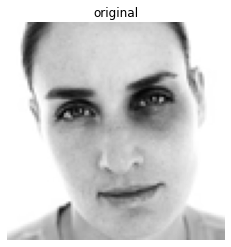

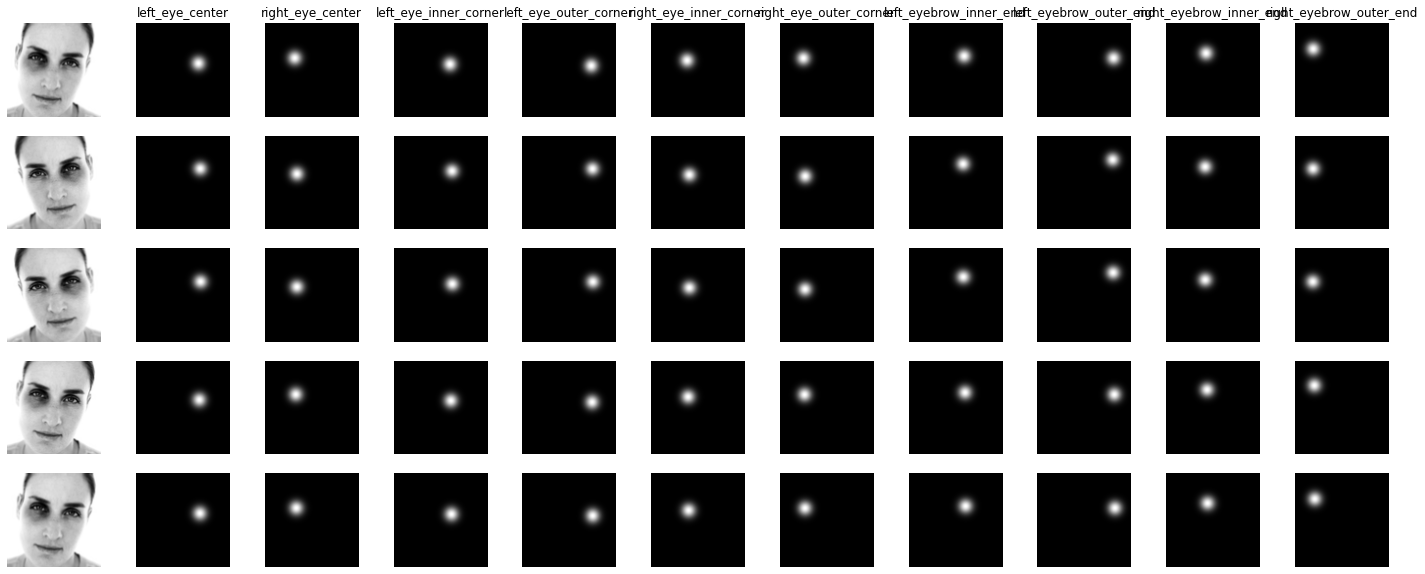

In [9]:
iexample = 139
## Show the first 13 heatmaps
Nhm = 10

plt.imshow(X_train[iexample,:,:,0],cmap="gray")
plt.title("original")
plt.axis("off")
plt.show()
Nplot = 5
fig = plt.figure(figsize=[Nhm*2.5,2*Nplot])


landmark_order = {"orig" : [0,1,2,3,4,5,6,7,8,9,11,12],
                  "new"  : [1,0,4,5,2,3,8,9,6,7,12,11]}


count = 1
for _ in range(Nplot):
    x_batch, y_batch = transform_imgs([X_train[[iexample]],
                                       y_train[[iexample]]],
                                     landmark_order)
    ax = fig.add_subplot(Nplot,Nhm+1,count)
    ax.imshow(x_batch[0,:,:,0],cmap="gray")
    ax.axis("off")
    count += 1 
    
    for ifeat in range(Nhm):
        ax = fig.add_subplot(Nplot,Nhm + 1,count)
        ax.imshow(y_batch[0,:,:,ifeat],cmap="gray")
        ax.axis("off")
        if count < Nhm + 2:
            ax.set_title(nm_landmarks[ifeat*2][:-2])
        count += 1
plt.show()

In [10]:
prop_train = 0.9
Ntrain = int(X_train.shape[0]*prop_train)
X_tra, y_tra, X_val,y_val = X_train[:Ntrain],y_train[:Ntrain],X_train[Ntrain:],y_train[Ntrain:]
del X_train, y_train

In [11]:
input_height, input_width = 96, 96
## output shape is the same as input
output_height, output_width = input_height, input_width 
n = 32*5
nClasses = 15
nfmp_block1 = 64
nfmp_block2 = 128

IMAGE_ORDERING =  "channels_last" 
img_input = Input(shape=(input_height,input_width, 1)) 

# Encoder Block 1
x = Conv2D(nfmp_block1, (3, 3), activation='relu', padding='same', name='block1_conv1', data_format=IMAGE_ORDERING )(img_input)
x = Conv2D(nfmp_block1, (3, 3), activation='relu', padding='same', name='block1_conv2', data_format=IMAGE_ORDERING )(x)
block1 = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', data_format=IMAGE_ORDERING )(x)
    
# Encoder Block 2
x = Conv2D(nfmp_block2, (3, 3), activation='relu', padding='same', name='block2_conv1', data_format=IMAGE_ORDERING )(block1)
x = Conv2D(nfmp_block2, (3, 3), activation='relu', padding='same', name='block2_conv2', data_format=IMAGE_ORDERING )(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', data_format=IMAGE_ORDERING )(x)
    
## bottoleneck    
o = (Conv2D(n, (input_height//4, input_width//4), 
            activation='relu' , padding='same', name="bottleneck_1", data_format=IMAGE_ORDERING))(x)
o = (Conv2D(n , ( 1 , 1 ) , activation='relu' , padding='same', name="bottleneck_2", data_format=IMAGE_ORDERING))(o)


## upsamping to bring the feature map size to be the same as the one from block1
## o_block1 = Conv2DTranspose(nfmp_block1, kernel_size=(2,2),  strides=(2,2), use_bias=False, name='upsample_1', data_format=IMAGE_ORDERING )(o)
## o = Add()([o_block1,block1])
## output   = Conv2DTranspose(nClasses,    kernel_size=(2,2),  strides=(2,2), use_bias=False, name='upsample_2', data_format=IMAGE_ORDERING )(o)

## Decoder Block
## upsampling to bring the feature map size to be the same as the input image i.e., heatmap size
output   = Conv2DTranspose(nClasses,    kernel_size=(4,4),  strides=(4,4), use_bias=False, name='upsample_2', data_format=IMAGE_ORDERING )(o)

## Reshaping is necessary to use sample_weight_mode="temporal" which assumes 3 dimensional output shape
## See below for the discussion of weights
output = Reshape((output_width*input_height*nClasses,1))(output)
model = Model(img_input, output)
model.summary()

model.compile(loss='mse',optimizer="rmsprop",sample_weight_mode="temporal")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0     

In [12]:
def find_weight(y_tra):
    '''
    :::input:::
    
    y_tra : np.array of shape (N_image, height, width, N_landmark)
    
    :::output::: 
    
    weights : 
        np.array of shape (N_image, height, width, N_landmark)
        weights[i_image, :, :, i_landmark] = 1 
                        if the (x,y) coordinate of the landmark for this image is recorded.
        else  weights[i_image, :, :, i_landmark] = 0

    '''
    weight = np.zeros_like(y_tra)
    count0, count1 = 0, 0
    for irow in range(y_tra.shape[0]):
        for ifeat in range(y_tra.shape[-1]):
            if np.all(y_tra[irow,:,:,ifeat] == 0):
                value = 0
                count0 += 1
            else:
                value = 1
                count1 += 1
            weight[irow,:,:,ifeat] = value
    print("N landmarks={:5.0f}, N missing landmarks={:5.0f}, weight.shape={}".format(
        count0,count1,weight.shape))
    return(weight)


def flatten_except_1dim(weight,ndim=2):
    '''
    change the dimension from:
    (a,b,c,d,..) to (a, b*c*d*..) if ndim = 2
    (a,b,c,d,..) to (a, b*c*d*..,1) if ndim = 3
    '''
    n = weight.shape[0]
    if ndim == 2:
        shape = (n,-1)
    elif ndim == 3:
        shape = (n,-1,1)
    else:
        print("Not implemented!")
    weight = weight.reshape(*shape)
    return(weight)

In [13]:
w_tra = find_weight(y_tra)

weight_val = find_weight(y_val)
weight_val = flatten_except_1dim(weight_val)
y_val_fla  = flatten_except_1dim(y_val,ndim=3) 

## print("weight_tra.shape={}".format(weight_tra.shape))
print("weight_val.shape={}".format(weight_val.shape))
print("y_val_fla.shape={}".format(y_val_fla.shape))
print(model.output.shape)

N landmarks=47185, N missing landmarks=47975, weight.shape=(6344, 96, 96, 15)
N landmarks= 5521, N missing landmarks= 5054, weight.shape=(705, 96, 96, 15)
weight_val.shape=(705, 138240)
y_val_fla.shape=(705, 138240, 1)
(None, 138240, 1)


In [14]:
# x_batch, y_batch, w_batch = transform_imgs([X_tra,y_tra, w_tra],landmark_order)
# If you want no data augementation, comment out the line above and uncomment the comment below:
x_batch, y_batch = X_tra, y_tra

# w_batch_fla = flatten_except_1dim(w_batch,ndim=2)
y_batch_fla = flatten_except_1dim(y_batch,ndim=3)

In [15]:
nb_epochs = 20 # 100
batch_size = 64
const = 10 
history = {"loss":[],"val_loss":[]}
# for iepoch in range(nb_epochs):
#     start = time.time()
    
# print(w_batch_fla.shape, y_batch_fla.shape)
print(y_batch_fla.shape)
hist = model.fit(x_batch,
                 y_batch_fla*const,
                 # sample_weight = w_batch_fla,
                 validation_data=(X_val,y_val_fla*const),#,weight_val),
                 batch_size=batch_size,
                 epochs=nb_epochs,
                 verbose=1)
    # history["loss"].append(hist.history["loss"][0])
    # history["val_loss"].append(hist.history["val_loss"][0])
    # end = time.time()
    # print("Epoch {:03}: loss {:6.4f} val_loss {:6.4f} {:4.1f}sec".format(
    #     iepoch+1,history["loss"][-1],history["val_loss"][-1],end-start))

(6344, 138240, 1)
Epoch 1/20
100/100 [==============================] - 27s 169ms/step - loss: 0.3681 - val_loss: 0.2396
Epoch 2/20
100/100 [==============================] - 16s 158ms/step - loss: 0.2441 - val_loss: 0.2275
Epoch 3/20
100/100 [==============================] - 16s 158ms/step - loss: 0.2000 - val_loss: 0.2721
Epoch 4/20
100/100 [==============================] - 16s 159ms/step - loss: 0.1681 - val_loss: 0.1433
Epoch 5/20
100/100 [==============================] - 16s 159ms/step - loss: 0.1482 - val_loss: 0.1809
Epoch 6/20
100/100 [==============================] - 16s 157ms/step - loss: 0.1369 - val_loss: 0.1222
Epoch 7/20
100/100 [==============================] - 16s 157ms/step - loss: 0.1236 - val_loss: 0.1195
Epoch 8/20
100/100 [==============================] - 16s 158ms/step - loss: 0.1167 - val_loss: 0.1357
Epoch 9/20
100/100 [==============================] - 16s 159ms/step - loss: 0.1084 - val_loss: 0.1380
Epoch 10/20
100/100 [==============================] - 

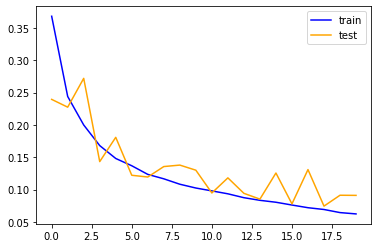

In [23]:
plt.plot(hist.history['loss'], color='blue', label='train')
plt.plot(hist.history['val_loss'], color='orange', label='test')
plt.legend()
plt.show()

In [27]:
y_pred = model.predict(X_val)
y_pred = y_pred.reshape(-1,output_height,output_width,nClasses)

Nlandmark = y_pred.shape[-1]
for i in range(96,100):
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(X_tra[i,:,:,0],cmap="gray")
    ax.axis("off")
    
    fig = plt.figure(figsize=(20,3))
    count = 1
    for j, lab in enumerate(nm_landmarks[::2]):
        ax = fig.add_subplot(2,Nlandmark,count)
        ax.set_title(lab[:10] + "\n" + lab[10:-2])
        ax.axis("off")
        count += 1
        ax.imshow(y_pred[i,:,:,j])
        if j == 0:
            ax.set_ylabel("prediction")
            
    for j, lab in enumerate(nm_landmarks[::2]):
        ax = fig.add_subplot(2,Nlandmark,count)
        count += 1
        ax.imshow(y_tra[i,:,:,j])   
        ax.axis("off")
        if j == 0:
            ax.set_ylabel("true")
    plt.show()

ResourceExhaustedError: Graph execution error:

Detected at node 'model/block1_conv2/Conv2D' defined at (most recent call last):
    File "C:\Users\MatiX\anaconda3\envs\py39\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\MatiX\anaconda3\envs\py39\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\MatiX\anaconda3\envs\py39\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\MatiX\anaconda3\envs\py39\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\MatiX\anaconda3\envs\py39\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\MatiX\anaconda3\envs\py39\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\MatiX\anaconda3\envs\py39\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "C:\Users\MatiX\anaconda3\envs\py39\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "C:\Users\MatiX\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\MatiX\anaconda3\envs\py39\lib\site-packages\ipykernel\kernelbase.py", line 473, in dispatch_queue
      await self.process_one()
    File "C:\Users\MatiX\anaconda3\envs\py39\lib\site-packages\ipykernel\kernelbase.py", line 462, in process_one
      await dispatch(*args)
    File "C:\Users\MatiX\anaconda3\envs\py39\lib\site-packages\ipykernel\kernelbase.py", line 369, in dispatch_shell
      await result
    File "C:\Users\MatiX\anaconda3\envs\py39\lib\site-packages\ipykernel\kernelbase.py", line 664, in execute_request
      reply_content = await reply_content
    File "C:\Users\MatiX\anaconda3\envs\py39\lib\site-packages\ipykernel\ipkernel.py", line 355, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\MatiX\anaconda3\envs\py39\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\MatiX\anaconda3\envs\py39\lib\site-packages\IPython\core\interactiveshell.py", line 2854, in run_cell
      result = self._run_cell(
    File "C:\Users\MatiX\anaconda3\envs\py39\lib\site-packages\IPython\core\interactiveshell.py", line 2900, in _run_cell
      return runner(coro)
    File "C:\Users\MatiX\anaconda3\envs\py39\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\MatiX\anaconda3\envs\py39\lib\site-packages\IPython\core\interactiveshell.py", line 3098, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\MatiX\anaconda3\envs\py39\lib\site-packages\IPython\core\interactiveshell.py", line 3301, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\MatiX\anaconda3\envs\py39\lib\site-packages\IPython\core\interactiveshell.py", line 3361, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\MatiX\AppData\Local\Temp\ipykernel_13608\1346713895.py", line 1, in <cell line: 1>
      y_pred = model.predict(X_tra)
    File "C:\Users\MatiX\anaconda3\envs\py39\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\MatiX\anaconda3\envs\py39\lib\site-packages\keras\engine\training.py", line 1982, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\MatiX\anaconda3\envs\py39\lib\site-packages\keras\engine\training.py", line 1801, in predict_function
      return step_function(self, iterator)
    File "C:\Users\MatiX\anaconda3\envs\py39\lib\site-packages\keras\engine\training.py", line 1790, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\MatiX\anaconda3\envs\py39\lib\site-packages\keras\engine\training.py", line 1783, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\MatiX\anaconda3\envs\py39\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
      return self(x, training=False)
    File "C:\Users\MatiX\anaconda3\envs\py39\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\MatiX\anaconda3\envs\py39\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\MatiX\anaconda3\envs\py39\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\MatiX\anaconda3\envs\py39\lib\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "C:\Users\MatiX\anaconda3\envs\py39\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\MatiX\anaconda3\envs\py39\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\MatiX\anaconda3\envs\py39\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\MatiX\anaconda3\envs\py39\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\MatiX\anaconda3\envs\py39\lib\site-packages\keras\layers\convolutional.py", line 248, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "C:\Users\MatiX\anaconda3\envs\py39\lib\site-packages\keras\layers\convolutional.py", line 233, in convolution_op
      return tf.nn.convolution(
Node: 'model/block1_conv2/Conv2D'
OOM when allocating tensor with shape[32,64,96,96] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/block1_conv2/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_8518]

In [ ]:
def get_ave_xy(hmi, n_points = 4, thresh=0):
    '''
    hmi      : heatmap np array of size (height,width)
    n_points : x,y coordinates corresponding to the top  densities to calculate average (x,y) coordinates
    
    
    convert heatmap to (x,y) coordinate
    x,y coordinates corresponding to the top  densities 
    are used to calculate weighted average of (x,y) coordinates
    the weights are used using heatmap
    
    if the heatmap does not contain the probability > 
    then we assume there is no predicted landmark, and 
    x = -1 and y = -1 are recorded as predicted landmark.
    '''
    if n_points < 1:
        ## Use all
        hsum, n_points = np.sum(hmi), len(hmi.flatten())
        ind_hmi = np.array([range(input_width)]*input_height)
        i1 = np.sum(ind_hmi * hmi)/hsum
        ind_hmi = np.array([range(input_height)]*input_width).T
        i0 = np.sum(ind_hmi * hmi)/hsum
    else:
        ind = hmi.argsort(axis=None)[-n_points:] ## pick the largest n_points
        topind = np.unravel_index(ind, hmi.shape)
        index = np.unravel_index(hmi.argmax(), hmi.shape)
        i0, i1, hsum = 0, 0, 0
        for ind in zip(topind[0],topind[1]):
            h  = hmi[ind[0],ind[1]]
            hsum += h
            i0   += ind[0]*h
            i1   += ind[1]*h

        i0 /= hsum
        i1 /= hsum
    if hsum/n_points <= thresh:
        i0, i1 = -1, -1
    return([i1,i0])

def transfer_xy_coord(hm, n_points = 64, thresh=0.2):
    '''
    hm : np.array of shape (height,width, n-heatmap)
    
    transfer heatmap to (x,y) coordinates
    
    the output contains np.array (Nlandmark * 2,) 
    * 2 for x and y coordinates, containing the landmark location.
    '''
    assert len(hm.shape) == 3
    Nlandmark = hm.shape[-1]
    #est_xy = -1*np.ones(shape = (Nlandmark, 2))
    est_xy = []
    for i in range(Nlandmark):
        hmi = hm[:,:,i]
        est_xy.extend(get_ave_xy(hmi, n_points, thresh))
    return(est_xy) ## (Nlandmark * 2,) 

def transfer_target(y_pred, thresh=0, n_points = 64):
    '''
    y_pred : np.array of the shape (N, height, width, Nlandmark)
    
    output : (N, Nlandmark * 2)
    '''
    y_pred_xy = []
    for i in range(y_pred.shape[0]):
        hm = y_pred[i]
        y_pred_xy.append(transfer_xy_coord(hm,n_points, thresh))
    return(np.array(y_pred_xy))

def getRMSE(y_pred_xy,y_train_xy,pick_not_NA):
    res = y_pred_xy[pick_not_NA] - y_train_xy[pick_not_NA]
    RMSE = np.sqrt(np.mean(res**2))
    return(RMSE)
nimage = 500 

rmelabels = ["(x,y) from est heatmap  VS (x,y) from true heatmap", 
             "(x,y) from est heatmap  VS true (x,y)             ",
             "(x,y) from true heatmap VS true (x,y)             "]
n_points_width = range(1,10)
res = []
n_points_final, min_rmse  = -1 , np.Inf
for nw in  n_points_width + [0]:
    n_points = nw * nw
    y_pred_xy = transfer_target(y_pred[:nimage],0,n_points)
    y_train_xy = transfer_target(y_tra[:nimage],0,n_points)
    pick_not_NA = (y_train_xy != -1)
    
    ts = [getRMSE(y_pred_xy,y_train_xy,pick_not_NA)]
    ts.append(getRMSE(y_pred_xy,y_train0.values[:nimage],pick_not_NA))
    ts.append(getRMSE(y_train_xy,y_train0.values[:nimage],pick_not_NA))
    
    res.append(ts)
    
    print("n_points to evaluate (x,y) coordinates = {}".format(n_points))
    print(" RMSE")
    for r, lab in zip(ts,rmelabels):
        print("  {}:{:5.3f}".format(lab,r))
    
    if min_rmse > ts[2]:
        min_rmse = ts[2]
        n_points_final = n_points
        
res = np.array(res)
for i, lab in enumerate(rmelabels):
    plt.plot(n_points_width + [input_width], res[:,i], label = lab)
plt.legend()
plt.ylabel("RMSE")
plt.xlabel("n_points")
plt.show()

In [ ]:
y_pred_test = model.predict(X_test)  ## estimated heatmap
y_pred_test = y_pred_test.reshape(-1,output_height,output_width,nClasses)
y_pred_test_xy = transfer_target(y_pred_test,thresh=0,n_points=n_points_final) ## estimated xy coord
y_pred_test_xy = pd.DataFrame(y_pred_test_xy,columns=nm_landmarks)
IdLookup = pd.read_csv(os.path.expanduser(FIdLookup))

def prepare_submission(y_pred4,loc):
    '''
    loc : the path to the submission file
    save a .csv file that can be submitted to kaggle
    '''
    ImageId = IdLookup["ImageId"]
    FeatureName = IdLookup["FeatureName"]
    RowId = IdLookup["RowId"]
    
    submit = []
    for rowId,irow,landmark in zip(RowId,ImageId,FeatureName):
        submit.append([rowId,y_pred4[landmark].iloc[irow-1]])
    
    submit = pd.DataFrame(submit,columns=["RowId","Location"])
    ## adjust the scale 
    submit["Location"] = submit["Location"]

    submit.to_csv(loc,index=False)
    print("File is saved at:" +  loc)
   
filename = "result/FCNish_point{:03.0f}.csv".format(n_points_final)
prepare_submission(y_pred_test_xy,filename)